In [32]:
from gwpy.timeseries import TimeSeries
import matplotlib
import gwpy
matplotlib.use("agg")
%matplotlib inline

We first load in the frame files of the first injection LGW220413. The waveform, apart from being amplified because of strong lensing, also happens to be microlensed with the lens parameters being $M_{L,z} = 2000$ and $y=0.5$. 

In [33]:
data_lensed = TimeSeries.read("H1_silence/lensed/H-H1_INJECTIONS-13338/H-H1_INJECTIONS-1333872942-40.gwf", "H1:INJECTIONS")
#data_lensed = data_type1.crop(1238782696,1238782699.1)
data_unlensed = TimeSeries.read("H1_silence/unlensed/H-H1_INJECTIONS-13338/H-H1_INJECTIONS-1333872942-40.gwf", "H1:INJECTIONS")
#data_unlensed = data_type2.crop(1238782696,1238782699.1)

We create a new gwpy timeseries by putting the lensed and unlensed waveform together. We also include the "residue", i.e. the difference between the two waveforms. 

In [59]:
combined = gwpy.timeseries.TimeSeriesDict()
combined['Lensed'] = data_lensed
combined['Unlensed'] = data_unlensed
combined['Residue'] = data_lensed - data_unlensed

Then we plot the lensed and unlensed waveforms, as well as the residue.

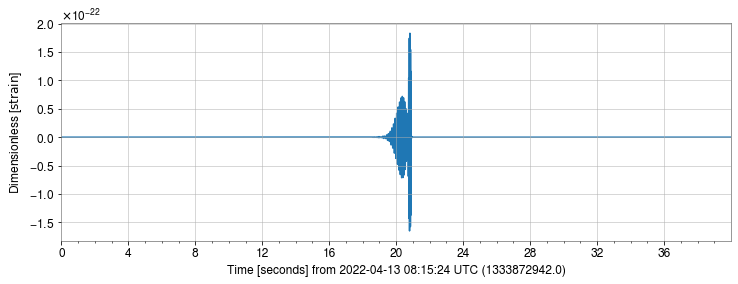

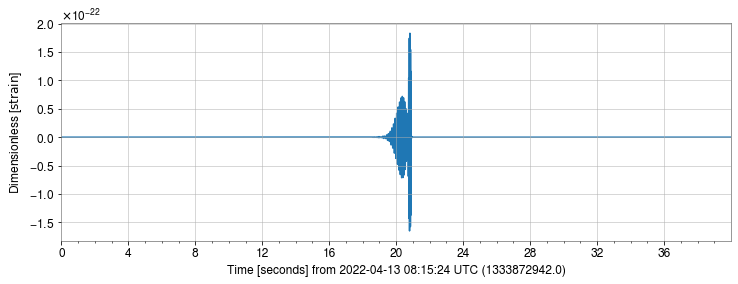

In [35]:
combined['Lensed'].plot()

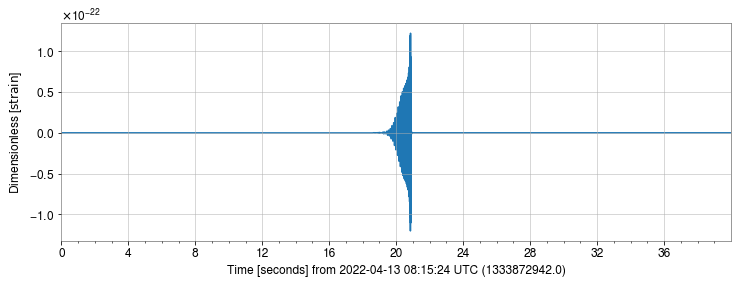

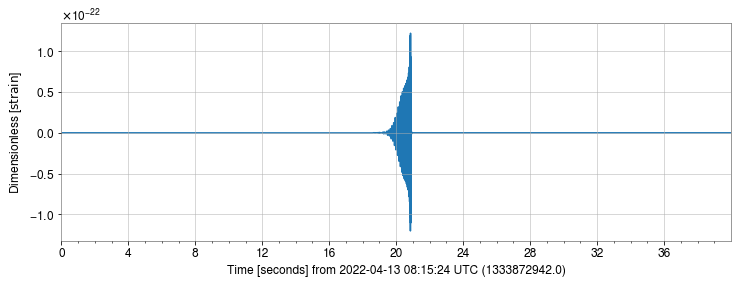

In [36]:
combined['Unlensed'].plot()

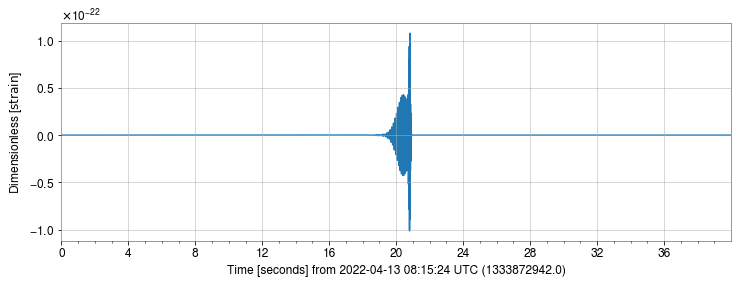

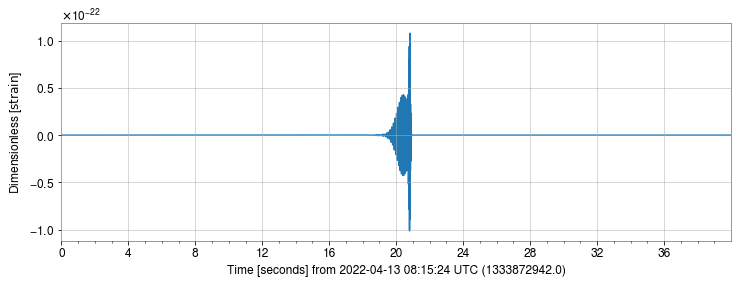

In [60]:
combined['Residue'].plot()

Next, we repeat the process but without the residue, and plot the lensed and unlensed waveforms together.

In [38]:
combined = gwpy.timeseries.TimeSeriesDict()
combined['Lensed'] = data_lensed
combined['Unlensed'] = data_unlensed

In [39]:
plot = combined.plot()
plot.legend()
plot.savefig("Microlensed_unlensed.pdf")

To verify LALSimulation is doing its job correctly, we use PyCBC to justify the results.

In [40]:
import pycbc.waveform as waveform

First, we create an unlensed frequecny domain waveform using the detector frame parameters.

In [62]:
tilde_h_plus, tilde_h_cross = waveform.get_fd_waveform(
    mass1 = 93.201586,
    mass2 = 73.622967,
    spin1x = 0.57770376,
    spin1y = 0.27610366,
    spin1z = 0.59569491,
    spin2x = 0.054885042,
    spin2y = 0.092867464,
    spin2z = -0.206526,
    distance = 7793.6201,
    coa_phase = 1.5825444,
    inclination = 0.067262278,
    f_lower = 10.,
    f_final = 8192.,
    approximant = "IMRPhenomXPHM",
    delta_f = 1./16.)

In [63]:
import numpy

We first plot the unlensed waveform to make sure it is reasonable.

(10.0, 14766.087579415835)

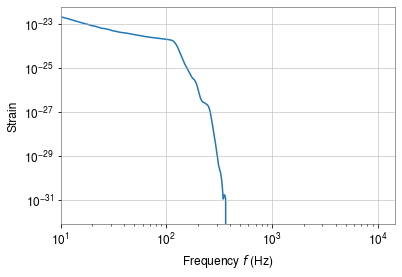

In [64]:
plt.plot(tilde_h_plus.sample_frequencies, numpy.abs(tilde_h_plus))
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Frequency $f$ (Hz)")
plt.ylabel("Strain")
plt.xlim(10.,)

Next, we load in the amplification factor array from the corresponding microlens. The data file consists of three columns: The sampling frequencies, and the real and complex part of the amplification factors. We did a transpose to make `data` in the shape of `number of sampling frequency` $\times$ $3$ (three columns). 

In [65]:
data = numpy.loadtxt("point_mlz_2000_y_0.5.dat")
data = data.transpose()

The following line is just to ensure the amplification factor array is large enough to cover the full waveform from the starting to ending frequency.

In [66]:
print(data[0][-1], tilde_h_plus.sample_frequencies[-1])

8192.0 8192.0


We then apply the amplification factor array to the unlensed waveform, hence creating the lensed waveforms.

In [67]:
tilde_h_plus_lensed = tilde_h_plus * (data[1]+1j * data[2])
tilde_h_cross_lensed =  tilde_h_cross * (data[1]+1j * data[2])

Then we plot the lensed and unlensed waveforms together.

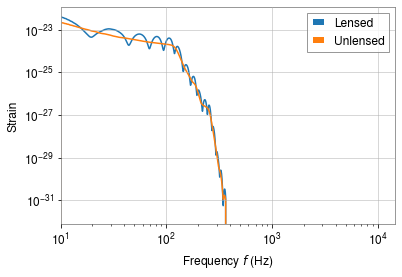

In [69]:
plt.plot(tilde_h_plus_lensed.sample_frequencies, numpy.abs(tilde_h_plus_lensed), label="Lensed")
plt.plot(tilde_h_plus.sample_frequencies, numpy.abs(tilde_h_plus), label="Unlensed")

plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Frequency $f$ (Hz)")
plt.ylabel("Strain")
plt.xlim(10.,)
plt.legend()

We then transform the waveform from the frequency domain to time domain. For illustrative purpose, we are only going to do so for the plus polarization (which means we are also ignoring the actual sky location of the source). 

In [70]:
h_plus = tilde_h_plus.to_timeseries()
h_plus_lensed = tilde_h_plus_lensed.to_timeseries()

Next, we plot the lensed and unlensed waveform together in the time domain. You may notice the burst at the start of the plot. This is an artifact from using `to_timeseries` from PyCBC, which can be fixed in principle, but for the purpose of this python notebook, we will leave it as it is. One might argue that the waveforms looks a little different from the one above, but one will need to understand that here we are only showing the waveform for the plus polarization, and we are completely ignoring sky location.

In [ ]:
plt.plot(h_plus_lensed.sample_times, h_plus_lensed,label="Lensed")
plt.plot(h_plus.sample_times, h_plus,c='orange',label="Unlensed")
plt.xlabel(r"Time to merger $(s)$")
plt.ylabel("Strain")
plt.legend()

Finally, we plot also the "residue".

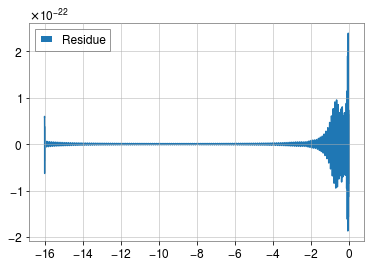

In [72]:
plt.plot(h_plus.sample_times, h_plus_lensed-h_plus,label="Residue")
plt.legend()